In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Feb 20 10:54:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Initialize Settings and import required packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pathname = "drive/MyDrive/Images"
print("[INFO] loading images...")
imagePaths = list(paths.list_images(pathname))
data = []
labels = []

[INFO] loading images...


## Import images with size of 224 x 224 and convert into numpy array

In [ ]:
for imagePath in imagePaths:
	# extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image) #preprocess for resnet usage

	# update the data and labels lists, respectively
  data.append(image)
  labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
# perform one-hot encoding on the labels, keras/deep learning models require inputs to be in numbers.
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

## Split data into Train and Test sets

In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=421)

In [ ]:
print('Total number of images:',len(data))
print('Total number if images in training set:',len(trainX))
print('Total number of images in testing set:',len(testX))

Total number of images: 3588
Total number if images in training set: 2870
Total number of images in testing set: 718


## Split 10% of data in Train into Validation

In [ ]:
(trainX, validationX, trainY, validationY) = train_test_split(trainX, 
                                                  trainY,
                                                  test_size=0.1,
                                                  stratify=trainY,
                                                  random_state=421)

In [ ]:
print('Total number of images in validation set:',len(validationX))
print('Final number of images in training set:',len(trainX))

Total number of images in validation set: 287
Final number of images in training set: 2583


# Initialize data augmentation parameters

In [ ]:
train_augmentation = ImageDataGenerator(
                                        rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.15,
                                        horizontal_flip=True,
                                        fill_mode="nearest")

# Tranfer learning via ResNet152V2

In [ ]:
INIT_LR = 0.001
EPOCHS = 100
BS = 32
adam_optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [ ]:
resnet = ResNet152V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
for layer in resnet.layers[:-4]:
    layer.trainable = False

234553344/234545216 [==============================] - 2s 0us/step


In [ ]:
resnet.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
x = resnet.output
x = AveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation="softmax")(x)

model = Model(inputs=resnet.input, outputs = outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(metrics=['accuracy'],
              optimizer=adam_optimizer,
              loss='binary_crossentropy')

## Fit the Model

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
classifier = model.fit(train_augmentation.flow(trainX, trainY, batch_size=BS),
                       steps_per_epoch=len(trainX) // BS,
                       validation_data=(validationX, validationY),
                       validation_steps = len(validationX) // BS,
                       epochs=EPOCHS, callbacks=[earlystop])

Epoch 1/100
80/80 [==============================] - 34s 418ms/step - loss: 0.0378 - accuracy: 0.9926 - val_loss: 0.0180 - val_accuracy: 0.9930
Epoch 2/100
80/80 [==============================] - 34s 420ms/step - loss: 0.0241 - accuracy: 0.9937 - val_loss: 0.0863 - val_accuracy: 0.9861
Epoch 3/100
80/80 [==============================] - 33s 417ms/step - loss: 0.0429 - accuracy: 0.9902 - val_loss: 0.0186 - val_accuracy: 0.9965
Epoch 4/100
80/80 [==============================] - 34s 420ms/step - loss: 0.0265 - accuracy: 0.9941 - val_loss: 0.0880 - val_accuracy: 0.9930
Epoch 5/100
80/80 [==============================] - 34s 419ms/step - loss: 0.0219 - accuracy: 0.9945 - val_loss: 0.0404 - val_accuracy: 0.9965
Epoch 6/100
80/80 [==============================] - 34s 418ms/step - loss: 0.0100 - accuracy: 0.9965 - val_loss: 0.0177 - val_accuracy: 0.9965
Epoch 7/100
80/80 [==============================] - 34s 418ms/step - loss: 0.0132 - accuracy: 0.9957 - val_loss: 0.0334 - val_accuracy:

## Visualize Accuracy and Loss Graphs

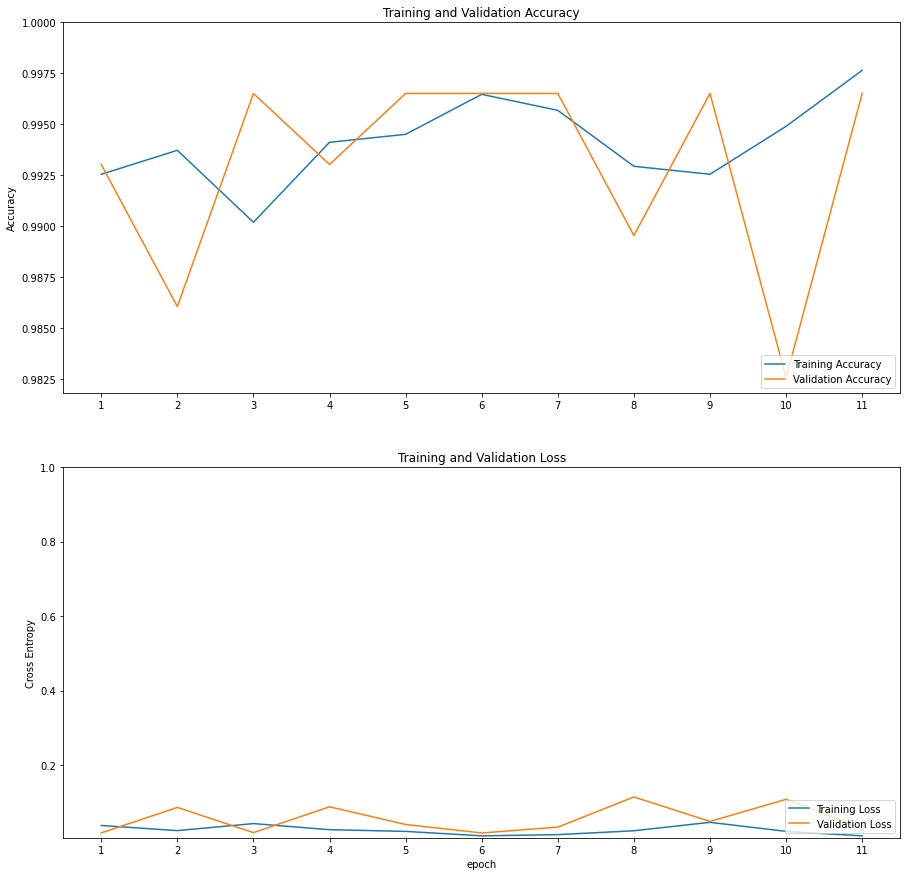

In [ ]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']

loss = classifier.history['loss']
val_loss = classifier.history['val_loss']

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.xticks(np.arange(len(acc)),np.arange(1,len(acc)+1))
plt.plot(acc, label ='Training Accuracy')
plt.plot(val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2,1,2)
plt.xticks(np.arange(len(loss)),np.arange(1,len(loss)+1))
plt.plot(loss, label ='Training Loss')
plt.plot(val_loss, label ='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
max_val_acc = val_acc.index(max(val_acc))
print('Maximum validation accuracy is achieved at epoch no.',max_val_acc+1,'with an accuracy of',round(val_acc[max_val_acc],4))

min_val_loss = val_loss.index(min(val_loss))
print('Minimum validation loss value is achieved at epoch no.',min_val_loss+1,'with a loss of',round(val_loss[min_val_loss],4))


Maximum validation accuracy is achieved at epoch no. 3 with an accuracy of 0.9965
Minimum validation loss value is achieved at epoch no. 6 with a loss of 0.0177


## Test model accuracy on test data

In [ ]:
test_loss, test_acc = model.evaluate(testX, testY)

23/23 [==============================] - 6s 237ms/step - loss: 0.0218 - accuracy: 0.9944


## Classification Report

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       359
without_mask       0.99      0.99      0.99       359

    accuracy                           0.99       718
   macro avg       0.99      0.99      0.99       718
weighted avg       0.99      0.99      0.99       718



In [ ]:
model.save('/content/drive/MyDrive/Sweehong/resnet152v2_mask_classification_model.h5', save_format="h5")